In [1]:
import pandas as pd
# def evaluate(df: pd.DataFrame):
#     ref_num = sum(df.event_triples.apply(lambda x: len(x)))
#     pred_num = sum(df.pred_event_triples.apply(lambda x: len(x)))
#     trg_match_cnt = 0
#     arg_match_cnt = 0
#     triple_match_cnt = 0
#     unmatched_trgs = []
#     incorrect_event_num = []
#     unmatched_args = []
#     for idx, row in df.iterrows():
#         if len(row.pred_event_triples) != len(row.event_triples): incorrect_event_num.append((row.event_triples, row.pred_event_triples))
#         for pred in row.pred_event_triples:
#             if len(pred) == 1:
#                 pred = ["", pred[0], ""]
#             elif len(pred) == 2:
#                 pred.append("")
#             trg_match = arg_match = triple_match = False
#             refs = row.event_triples
#             for ref in refs:
#                 if pred == ref: triple_match = True
#                 if pred[1]==ref[1]: trg_match = True
#                 tmp_pred, tmp_ref = pred.copy(), ref.copy()
#                 tmp_pred.pop(1)
#                 tmp_ref.pop(1)
#                 if tmp_pred == tmp_ref: arg_match = True
#             if trg_match: trg_match_cnt += 1
#             else: unmatched_trgs.append((pred[1], row.event_triples))
#             if arg_match: arg_match_cnt += 1
#             else: unmatched_args.append(row.event_triples)
#             if triple_match: triple_match_cnt += 1
#     F1 = lambda p,r: "{:.5f}".format(2*p*r/(p+r))
#     trg_p, arg_p, trp_p = trg_match_cnt/pred_num, arg_match_cnt/pred_num, triple_match_cnt/pred_num
#     trg_r, arg_r, trp_r = trg_match_cnt/ref_num, arg_match_cnt/ref_num, triple_match_cnt/ref_num
#     trg_f, arg_f, trp_f = F1(trg_p, trg_r), F1(arg_p, arg_r), F1(trp_p, trp_r)

#     from tabulate import tabulate
#     header = ["task", "Precision", "Recall", "F1"]
#     rows = [
#         ("Trigger Identification", trg_p, trg_r, trg_f),
#         ("Argument Identification", arg_p, arg_r, arg_f),
#         ("Triple Identification", trp_p, trp_r, trp_f),
#     ]

def evaluate(df: pd.DataFrame, ans_col='event_triples', pred_col='pred_event_triples', verbose=True):
    gold_trp_num = sum(df[ans_col].apply(lambda x: len(x)))
    pred_trp_num = sum(df[pred_col].apply(lambda x: len(x)))
    gold_trg_num, gold_arg_num, pred_trg_num, pred_arg_num = 0, 0, 0, 0
    trg_match_cnt, arg_match_cnt, triple_match_cnt = 0, 0, 0
    matched_triples = []
    for idx, row in df.iterrows():
        local_triple_match_cnt = 0
        gold_trips = list(row[ans_col])
        gold_trgs = [trp[1] for trp in row[ans_col]]
        gold_sbjs = [{"P": trp[1], "S": trp[0]} for trp in row[ans_col] if trp[0]!='']
        gold_objs = [{"P": trp[1], "O": trp[2]} for trp in row[ans_col] if trp[2]!='']
        gold_trg_num += len(gold_trgs)
        gold_arg_num += (len(gold_sbjs) + len(gold_objs))
        for pred in row[pred_col]:
            pred_trg_num += 1
            if len(pred) == 1:
                pred = ["", pred[0], ""]
            elif len(pred) == 2:
                pred.append("")
            if pred in gold_trips:
                local_triple_match_cnt += 1
                triple_match_cnt += 1
                gold_trips.remove(pred)
                matched_triples.append(pred)
            if pred[0] != '': pred_arg_num += 1
            if pred[2] != '': pred_arg_num += 1
            if pred[1] in gold_trgs:
                trg_match_cnt += 1
                gold_trgs.remove(pred[1])
            if {"P": pred[1], "S": pred[0]} in gold_sbjs:
                arg_match_cnt += 1
                gold_sbjs.remove({"P": pred[1], "S": pred[0]})
            if {"P": pred[1], "O": pred[2]} in gold_objs:
                arg_match_cnt += 1
                gold_objs.remove({"P": pred[1], "O": pred[2]})
        # # compute micro f1 for triplet
        # if len(row[pred_col])>0:
        #     p, r = local_triple_match_cnt / (len(row[pred_col])+1e-6), local_triple_match_cnt / (len(gold_trips)+1e-6)
        #     micro_triple_f1.append(2*p*r/(p+r+1e-6))
        # else: micro_triple_f1.append(0)

    F1 = lambda p,r: "{:.5f}".format(2*p*r/(p+r))
    trg_p, arg_p, trp_p = trg_match_cnt/pred_trg_num, arg_match_cnt/pred_arg_num, triple_match_cnt/pred_trp_num
    trg_r, arg_r, trp_r = trg_match_cnt/gold_trg_num, arg_match_cnt/gold_arg_num, triple_match_cnt/gold_trp_num
    trg_f, arg_f, trp_f = F1(trg_p, trg_r), F1(arg_p, arg_r), F1(trp_p, trp_r)

    if verbose:
        from tabulate import tabulate
        header = ["task", "Precision", "Recall", "F1"]
        rows = [
            ("Trigger Identification", trg_p, trg_r, trg_f),
            ("Argument Identification", arg_p, arg_r, arg_f),
            ("Triple Identification", trp_p, trp_r, trp_f),
        ]

        print(tabulate(rows, headers=header))
        print("gold num > {}".format({"trp": gold_trg_num, "trg": gold_trg_num, "arg": gold_arg_num}))
        print("pred num > {}".format({"trp": pred_trp_num, "trg": pred_trg_num, "arg": pred_arg_num}))
        print("trg match: %d, arg match: %d, trp match: %d" % (trg_match_cnt, arg_match_cnt, triple_match_cnt))
    return trg_f, arg_f, trp_f, matched_triples

In [2]:
trg_df = pd.read_csv("output/trg_ner/bert-base-chinese/trg_predictions.csv")
trg_df['triggers'] = trg_df['triggers'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
trg_df['pred_triggers'] = trg_df['pred_triggers'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
gold_trg_num, trg_num, trg_match_cnt = 0, 0, 0
for i, row in trg_df.iterrows():
    gold_trg_num += len(row.triggers)
    trg_num += len(row.pred_triggers)
    refs = list(row.triggers)
    for trg in row.pred_triggers:
        if trg in refs:
            trg_match_cnt += 1
            refs.remove(trg)
p, r = trg_match_cnt/trg_num, trg_match_cnt/gold_trg_num
f1 = 2*p*r/(p+r)
print("P: {}, R: {}, F1: {}".format(p,r,f1))

FileNotFoundError: [Errno 2] No such file or directory: 'output/trg_ner/bert-base-chinese/trg_predictions.csv'

In [4]:
df = pd.DataFrame(columns=['pred_trg', 'ner', 'qa'])
for i in range(len(ner_df)):
    if len(trg_df['pred_triggers'][i]) != len(ner_df['pred_event_triples'][i]) != len(tmp_df['pred_event_triples'][i]):
        df.loc[i] = {'pred_trg': trg_df['pred_triggers'][i], 'ner': ner_df['pred_event_triples'][i], 'qa': tmp_df['pred_event_triples'][i]}

NameError: name 'ner_df' is not defined

In [5]:
tst_df = pd.read_csv("../datasets/TencentNews/test.csv").fillna("None")
for i in range(1,7):
    tst_df[f'event{i}_triple'] = tst_df[f'event{i}_triple'].apply(lambda x: list(eval(x.lower().replace(" ", "").replace(":", "："))) if eval(x) !=None else None)
tst_df['event_triples'] = tst_df[[f'event{i}_triple' for i in range(1,7)]].apply(lambda row: [x for x in row if x!=None], axis=1)

In [19]:
print("=============== NER ===============")
ner_df = pd.read_csv("output/arg_ner/bert-base-chinese/pipeline_predictions.csv")
# df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
ner_df.drop("event_triples", axis=1, inplace=True)
ner_df['event_triples'] = tst_df['event_triples']
ner_df['pred_event_triples'] = ner_df['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
ner_df['pred_event_triples'] = ner_df['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
seqtag_matched = evaluate(ner_df)

ner_df2 = pd.read_csv("output/arg_ner/bert-base-chinese/arg_predictions.csv")
# df2['event_triples'] = df2['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
ner_df2.drop("event_triples", axis=1, inplace=True)
ner_df2['event_triples'] = tst_df['event_triples']
ner_df2['pred_event_triples'] = ner_df2['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
ner_df2['pred_event_triples'] = ner_df2['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
_ = evaluate(ner_df2)

=============== NER ===============
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      0.694741  0.698572  0.69665
Argument Identification     0.508037  0.512265  0.51014
Triple Identification       0.410714  0.412979  0.41184
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7112, 'trg': 7112, 'arg': 11633}
trg match: 4941, arg match: 5910, trp match: 2921
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      1         0.996183  0.99809
Argument Identification     0.703723  0.696282  0.69998
Triple Identification       0.572665  0.570479  0.57157
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7046, 'trg': 7046, 'arg': 11415}
trg match: 7046, arg match: 8033, trp match: 4035


In [218]:
# print("=============== NER+Prefix ===============")
# df = pd.read_csv("output/arg_ner_with_prefix/bert-base-chinese/pipeline_predictions.csv")
# # df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df.drop("event_triples", axis=1, inplace=True)
# df['event_triples'] = tst_df['event_triples']
# df['pred_event_triples'] = df['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df['pred_event_triples'] = df['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
# evaluate(df)

# df2 = pd.read_csv("output/arg_ner_with_prefix/bert-base-chinese/arg_predictions.csv")
# # df2['event_triples'] = df2['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df2.drop("event_triples", axis=1, inplace=True)
# df2['event_triples'] = tst_df['event_triples']
# df2['pred_event_triples'] = df2['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df2['pred_event_triples'] = df2['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
# evaluate(df2)

In [20]:
print("=============== NER-SpanMRC ===============")
qa_df = pd.read_csv("output/arg_qa/bert-base-chinese/pipeline_predictions.csv")
qa_df['pred_event_triples'] = qa_df['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
qa_df['pred_event_triples'] = qa_df['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
tmp_df = tst_df.copy()
tmp_df['pred_event_triples'] = [[]]*len(tmp_df)
for i, row in qa_df.iterrows():
    idx = tmp_df[tmp_df['title_id']==row.title_id].index.values[0]
    tmp_df.at[idx, 'pred_event_triples'] = row['pred_event_triples']
# df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df.drop("event_triples", axis=1, inplace=True)
# df['event_triples'] = tst_df['event_triples']
qa_df = tmp_df.copy()
spanmrc_matched = evaluate(qa_df)

qa_df2 = pd.read_csv("output/arg_qa/bert-base-chinese/arg_predictions.csv")
# df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
qa_df2['event_triples'] = tst_df['event_triples']
qa_df2['pred_event_triples'] = qa_df2['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
qa_df2['pred_event_triples'] = qa_df2['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
_ = evaluate(qa_df2)

=============== NER-SpanMRC ===============
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      0.698778  0.70352   0.70114
Argument Identification     0.600778  0.549016  0.57373
Triple Identification       0.445022  0.448042  0.44653
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7121, 'trg': 7121, 'arg': 10543}
trg match: 4976, arg match: 6334, trp match: 3169
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      1         0.999717  0.99986
Argument Identification     0.829264  0.747681  0.78636
Triple Identification       0.614623  0.614449  0.61454
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7071, 'trg': 7071, 'arg': 10402}
trg match: 7071, arg match: 8626, trp match: 4346


In [21]:
print("=============== NER-Seq2SeqMRC ===============")
seq2seq_qa_df = pd.read_csv("output/arg_seq2seq_qa/mt5-base/pipeline_predictions.csv")
seq2seq_qa_df['pred_event_triples'] = seq2seq_qa_df['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
seq2seq_qa_df['pred_event_triples'] = seq2seq_qa_df['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
tmp_df = tst_df.copy()
tmp_df['pred_event_triples'] = [[]]*len(tmp_df)
for i, row in seq2seq_qa_df.iterrows():
    idx = tmp_df[tmp_df['title_id']==row.title_id].index.values[0]
    tmp_df.at[idx, 'pred_event_triples'] = row['pred_event_triples']
# df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
# df.drop("event_triples", axis=1, inplace=True)
# df['event_triples'] = tst_df['event_triples']
seq2seq_qa_df = tmp_df.copy()
seq2seqmrc_matched = evaluate(seq2seq_qa_df)

seq2seq_qa_df2 = pd.read_csv("output/arg_seq2seq_qa/mt5-base/arg_predictions.csv")
# df['event_triples'] = df['event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
seq2seq_qa_df2['event_triples'] = tst_df['event_triples']
seq2seq_qa_df2['pred_event_triples'] = seq2seq_qa_df2['pred_event_triples'].apply(lambda x: eval(x.lower().replace(" ", "").replace(":", "：")))
seq2seq_qa_df2['pred_event_triples'] = seq2seq_qa_df2['pred_event_triples'].apply(lambda x: [i for i in x if i!=[]])
_ = evaluate(seq2seq_qa_df2)


=============== NER-Seq2SeqMRC ===============
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      0.698778  0.70352   0.70114
Argument Identification     0.578826  0.586201  0.58249
Triple Identification       0.497683  0.50106   0.49937
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7121, 'trg': 7121, 'arg': 11684}
trg match: 4976, arg match: 6763, trp match: 3544
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      1         0.999717  0.99986
Argument Identification     0.806084  0.803848  0.80496
Triple Identification       0.694668  0.694472  0.69457
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 7071, 'trg': 7071, 'arg': 11505}
trg match: 7071, arg match: 9274, trp match: 4912


In [10]:
# for ltp_srl
df2 = pd.read_excel("output/test-ltp结果.xlsx").fillna("None")
df2['pred_event_triples'] = df2['ltp结果'].apply(lambda x: [list(i) for i in eval(x)] if eval(x)!=None else [])
df2['pred_event_triples'] = df2['pred_event_triples'].apply(lambda lst: [x for x in lst if x!=[]])
# for i in range(1,7):
#     df2[f'event{i}_triple'] = df2[f'event{i}_triple'].apply(lambda x: list(eval(x)) if eval(x) !=None else None)
# df2['event_triples'] = df2[[f'event{i}_triple' for i in range(1,7)]].apply(lambda row: [x for x in row if x!=None], axis=1)
df2['event_triples'] = tst_df['event_triples']
evaluate(df2)

task                       Precision     Recall       F1
-----------------------  -----------  ---------  -------
Trigger Identification     0.210306   0.320232   0.25388
Argument Identification    0.119647   0.15524    0.13514
Triple Identification      0.0448468  0.0682879  0.05414
gold num > {'trp': 7073, 'trg': 7073, 'arg': 11537}
pred num > {'trp': 10770, 'trg': 10770, 'arg': 14969}
trg match: 2265, arg match: 1791, trp match: 483


('0.25388',
 '0.13514',
 '0.05414',
 [['农发行正定县支行', '组织', '员工'],
  ['男子', '买', '饮料'],
  ['男子', '拿', '苹果'],
  ['国家大剧院', '进入', '维保期'],
  ['华为云', '驶入', '互联网基建深水区'],
  ['国家发改委', '批复', ''],
  ['中央', '投资', '3.7亿元'],
  ['女子', '上', '厕所'],
  ['惠州市政府', '召开', '党组会议和常务会议'],
  ['沪指', '收报', '3639.78点'],
  ['赵雅芝', '携', '老公'],
  ['伦镍', '暴涨', ''],
  ['平顺县', '召开', '民营企业助力乡村振兴工作交流会'],
  ['世界冠军', '输', '中国选手'],
  ['赵心童小组', '夺冠', ''],
  ['经纪人', '联系', '大巴黎'],
  ['第三方调查公司', '发布', '测评结果'],
  ['汤普森', '推迟', '复出'],
  ['木鸟民宿', '发布', '2022元旦假期民宿预订数据报告'],
  ['开发商', '回应', ''],
  ['深圳龙华区实验学校', '招', '25人'],
  ['球迷', '揭开', '内幕'],
  ['艾顿', '送', '祝福'],
  ['隆化县消防救援大队', '开展', '学雷锋活动'],
  ['一新冠阳性人员', '参加', '婚宴'],
  ['洛江生态环境局', '深化', '执法练兵成效'],
  ['莫兰特', '甩开', '杜兰特'],
  ['莱因克尔', '谈', '塞塞尼翁'],
  ['神农架林区公安局', '招', '14人'],
  ['00后组合', '问鼎', '男双'],
  ['张瑞蒯曼', '赢得', '女双冠军'],
  ['武汉', '增加', '20万余中小学学位'],
  ['梁洛施', '晒', '儿子正脸照'],
  ['巨石强森', '炮轰', '范迪塞尔'],
  ['山东', '出台', '文件'],
  ['新晃侗族自治县人民检察院', '聘请', '首批特邀检察官助理'],
  ['现货黄金', '创', '新

# Analysis

In [28]:
import matplotlib.pyplot as plt
import numpy as np

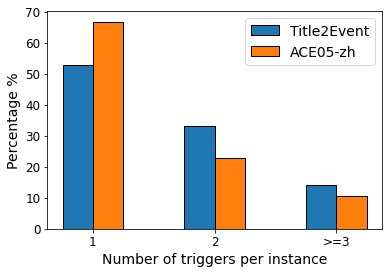

In [136]:
# Fig. 3 topic disribution
from tkinter import font


fig, ax = plt.subplots()
trg_num = [1,2,3]
x=np.arange(len(trg_num))
width=0.25

t2e = [22626, 14136, 6107]
t2e_per = [100*n for n in t2e/np.sum(t2e)]
ace = [1513, 515, 240]
ace_per = [100*n for n in ace/np.sum(ace)]


ax.bar(x=x-width/2, height=t2e_per, width=width, label='Title2Event', edgecolor='black')
ax.bar(x=x+width/2, height=ace_per, width=width, label='ACE05-zh', edgecolor='black')

ax.set_ylabel('Percentage %',  fontsize=14)
ax.set_xlabel('Number of triggers per instance', fontsize=14)
ax.set_xticks(x, [1,2,'>=3'], fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=14)
# plt.show()
plt.savefig('trigger_dist.pdf')

In [194]:
## Fig. 5 esults on instances containing different number of events.

tst_df.columns
tst_df = tst_df[['title_id', 'title', 'topic', 'event_triples']]
tst_df['seqtag_pipe'] = ner_df['pred_event_triples']
tst_df['seqtag'] = ner_df2['pred_event_triples']
tst_df['spanmrc_pipe'] = qa_df['pred_event_triples']
tst_df['spanmrc'] = qa_df2['pred_event_triples']
tst_df['seq2seqmrc_pipe'] = seq2seq_qa_df['pred_event_triples']
tst_df['seq2seqmrc'] = seq2seq_qa_df2['pred_event_triples']

# tst_df.to_excel('all_model_outputs2.xlsx')

tst_df['triple_cnt'] = tst_df['event_triples'].apply(lambda trps: len(trps))
# tst_df.groupby('triple_cnt').count()
# tst_df['triple_cnt'] = tst_df['triple_cnt'].apply(lambda x: ">3" if x>3 else str(x))


seqtag_trg = []
seqtag_arg, spanmrc_arg, seq2seqmrc_arg = [], [], []
seqtag_trp, spanmrc_trp, seq2seqmrc_trp = [], [], []

for i in [1,2]:
    trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='seqtag_pipe')
    _, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='seqtag')
    trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
    seqtag_trg.append(trg)
    seqtag_arg.append(arg)
    seqtag_trp.append(trp)
    trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='spanmrc_pipe')
    _, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='spanmrc')
    trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
    spanmrc_arg.append(arg)
    spanmrc_trp.append(trp)
    trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='seq2seqmrc_pipe')
    _, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']==i], pred_col='seq2seqmrc')
    trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
    seq2seqmrc_arg.append(arg)
    seq2seqmrc_trp.append(trp)

trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='seqtag_pipe')
_, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='seqtag')
trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
seqtag_trg.append(trg)
seqtag_arg.append(arg)
seqtag_trp.append(trp)
trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='spanmrc_pipe')
_, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='spanmrc')
trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
spanmrc_arg.append(arg)
spanmrc_trp.append(trp)
trg, _, trp, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='seq2seqmrc_pipe')
_, arg, _, _ = evaluate(tst_df[tst_df['triple_cnt']>i], pred_col='seq2seqmrc')
trg, arg, trp = 100*eval(trg), 100*eval(arg), 100*eval(trp)
seq2seqmrc_arg.append(arg)
seq2seqmrc_trp.append(trp)

task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      0.688889  0.808576  0.74395
Argument Identification     0.495694  0.580568  0.53478
Triple Identification       0.388701  0.456233  0.41977
gold num > {'trp': 2262, 'trg': 2262, 'arg': 3767}
pred num > {'trp': 2655, 'trg': 2655, 'arg': 4412}
trg match: 1829, arg match: 2187, trp match: 1032
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      1         1         1
Argument Identification     0.710975  0.708521  0.70975
Triple Identification       0.564987  0.564987  0.56499
gold num > {'trp': 2262, 'trg': 2262, 'arg': 3767}
pred num > {'trp': 2262, 'trg': 2262, 'arg': 3754}
trg match: 2262, arg match: 2669, trp match: 1278
task                       Precision    Recall       F1
-----------------------  -----------  --------  -------
Trigger Identification      0.

In [212]:
seq2seqmrc_arg

[83.608, 79.52, 78.179]

In [204]:
x=np.arange(len(trg_num))

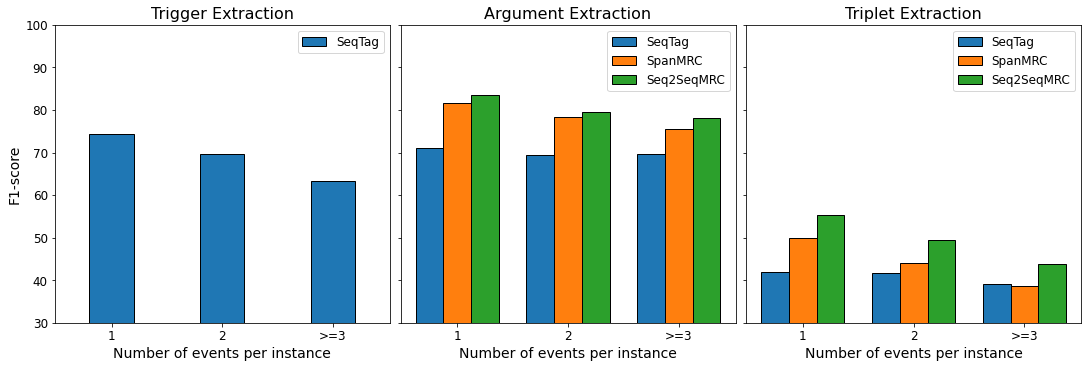

In [209]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5), layout='constrained', sharex=True, sharey=True)
params = {"fontsize": 14}
ax1.set_xlabel("Number of events per instance", **params)
ax2.set_xlabel("Number of events per instance", **params)
ax3.set_xlabel("Number of events per instance", **params)
ax1.set_ylabel("F1-score", **params)
params['fontsize']=16
ax1.set_title("Trigger Extraction", **params)
ax2.set_title("Argument Extraction", **params)
ax3.set_title("Triplet Extraction", **params)
ax1.set_xticks(x, [1,2, '>=3'])
# ax1.set_yticks([0.4, 0.5])
ax1.set_ylim((30, 100))

trg_num = [1,2,3]
x=np.arange(len(trg_num))

width=0.4
ax1.bar(x=x, height=seqtag_trg, width=width, label='SeqTag', edgecolor='black')
ax1.legend(fontsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

width=0.25
ax2.bar(x=x-width, height=seqtag_arg, width=width, label='SeqTag', edgecolor='black')
ax2.bar(x=x, height=spanmrc_arg, width=width, label='SpanMRC', edgecolor='black')
ax2.bar(x=x+width, height=seq2seqmrc_arg, width=width, label='Seq2SeqMRC', edgecolor='black')
ax2.legend(fontsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax3.bar(x=x-width, height=seqtag_trp, width=width, label='SeqTag', edgecolor='black')
ax3.bar(x=x, height=spanmrc_trp, width=width, label='SpanMRC', edgecolor='black')
ax3.bar(x=x+width, height=seq2seqmrc_trp, width=width, label='Seq2SeqMRC', edgecolor='black')
ax3.legend(fontsize=12)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

plt.show()
# plt.savefig('result_analysis.pdf')



In [12]:
# get triggers count
tst_df['trigger'] = tst_df['event_triples'].apply(lambda x : [tu[1] for tu in x])
predicates = []
for i, row in tst_df.iterrows():
    predicates.extend(row.trigger)
tst_trg_df = pd.DataFrame({"trigger": predicates, "count": 0}) 
tst_trg_df = tst_trg_df.groupby("trigger").count().reset_index().sort_values(by='count', ascending=False)

trn_df = pd.read_csv('../datasets/TencentNews/train.csv')

trn_df['triples'] = trn_df[[f"event{i}_triple" for i in range(1,7)]].apply(lambda row: [eval(item) for item in row if isinstance(item, str)], axis=1)
trn_df['trigger'] = trn_df['triples'].apply(lambda x : [tu[1] for tu in x])
predicates = []
for i, row in trn_df.iterrows():
    predicates.extend(row.trigger)
trn_trg_df = pd.DataFrame({"trigger": predicates, "count": 0}) 
trn_trg_df = trn_trg_df.groupby("trigger").count().sort_values(by='count', ascending=False)

In [213]:
topics = ["社会", "财经", "体育", "时事", "科技", "娱乐", "教育", "汽车", "天气", "军事"]
df = pd.DataFrame(index=topics, columns=['trgEx_seqtag', 'argEx_seqtag', 'argEx_spanmrc', 'argEx_seq2seqmrc'])

In [14]:
df

,trgEx_seqtag,argEx_seqtag,argEx_spanmrc,argEx_seq2seqmrc
社会,NaN,NaN,NaN,NaN
财经,NaN,NaN,NaN,NaN
体育,NaN,NaN,NaN,NaN
时事,NaN,NaN,NaN,NaN
科技,NaN,NaN,NaN,NaN
娱乐,NaN,NaN,NaN,NaN
教育,NaN,NaN,NaN,NaN
汽车,NaN,NaN,NaN,NaN
天气,NaN,NaN,NaN,NaN
军事,NaN,NaN,NaN,NaN


In [214]:
# evaluate the performance of different topics
topics = ["社会", "财经", "体育", "时事", "科技", "娱乐", "教育", "汽车", "天气", "军事", 
        '旅游', '房产', '三农', '文化', '综艺', '游戏', '电影', '健康', '电视剧', '历史', '音乐', '科学', '生活', 
        '美食', '情感', '育儿', '时尚', '宠物', '职场', '曲艺', '动漫', '摄影', '搞笑', '其它']
df = pd.DataFrame(index=topics, columns=['trgEx_seqtag', 'argEx_seqtag', 'argEx_spanmrc', 'argEx_seq2seqmrc'])
cnts = []
for topic in topics:
    # print(f"========== {topic} ===========")
    tmp_df = tst_df[tst_df['topic']==topic]
    cnts.append(len(tmp_df))
    for model in ['seqtag_pipe', 'seqtag', 'spanmrc', 'seq2seqmrc']:
        try:
            trg_f, arg_f, trp_f, _ = evaluate(tmp_df, pred_col=model, verbose=False)
        except:
            trg_f, arg_f, trp_f, _ = None, None, None, None
        if model=='seqtag_pipe':
            df.loc[topic]['trgEx_seqtag'] = trg_f
        else:
            df.loc[topic][f'argEx_{model}'] = arg_f 
df = df.astype('float').round(3)
for col in df.columns:
    df[col] = df[col] * 100
df.insert(0, column='cnt', value=cnts)

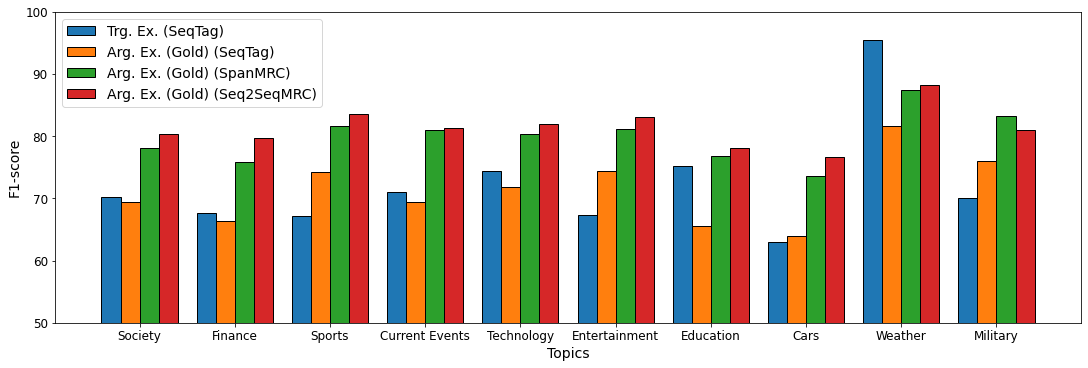

In [217]:
tmp_df = df[:10]
fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')
ax.set_xlabel('Topics', fontsize=14)
ax.set_ylabel('F1-score', fontsize=14)

x=np.arange(10)
width=0.2
ax.bar(x=x-1.5*width, height=tmp_df.trgEx_seqtag, width=width, label='Trg. Ex. (SeqTag)', edgecolor='black')
ax.bar(x=x-0.5*width, height=tmp_df.argEx_seqtag, width=width, label='Arg. Ex. (Gold) (SeqTag)', edgecolor='black')
ax.bar(x=x+0.5*width, height=tmp_df.argEx_spanmrc, width=width, label='Arg. Ex. (Gold) (SpanMRC)', edgecolor='black')
ax.bar(x=x+1.5*width, height=tmp_df.argEx_seq2seqmrc, width=width, label='Arg. Ex. (Gold) (Seq2SeqMRC)', edgecolor='black')

x_labels=["Society", "Finance", "Sports", "Current Events", "Technology", "Entertainment", "Education", "Cars", "Weather", "Military"]
ax.set_xticks(x, x_labels, fontsize=12)
ax.set_ylim((50, 100))
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=14)

plt.savefig('figs/topic_result.pdf')

['社会',
 '财经',
 '体育',
 '时事',
 '科技',
 '娱乐',
 '教育',
 '汽车',
 '天气',
 '军事',
 '旅游',
 '房产',
 '三农',
 '文化',
 '综艺',
 '游戏',
 '电影',
 '健康',
 '电视剧',
 '历史',
 '音乐',
 '科学',
 '生活',
 '美食',
 '情感',
 '育儿',
 '时尚',
 '宠物',
 '职场',
 '曲艺',
 '动漫',
 '摄影',
 '搞笑',
 '其它']

In [9]:
import numpy as np
def compute(matched_df):
    matched_trgs = [tu[1] for tu in matched_df]
    matched_trgs_df = pd.DataFrame({"trigger": matched_trgs, "match_count": 0})
    matched_trgs_df = matched_trgs_df.groupby("trigger").count().sort_values(by="match_count")
    triggers = []
    recalls = []
    trn_counts = []
    for i, row in tst_trg_df.iterrows():
        if row.trigger in matched_trgs_df.index:
            recalls.append(matched_trgs_df.loc[row.trigger].match_count / row['count'])
        else: recalls.append(0)
        if row.trigger in trn_trg_df.index:
            trn_counts.append(trn_trg_df.loc[row.trigger]['count'])
        else: trn_counts.append(0)
    tmp_df = pd.DataFrame({"count": trn_counts, "recall": recalls}).sort_values("count", ascending=True)
    tmp_df = tmp_df.groupby('count').agg(lambda x: np.mean(x)).reset_index()
    
    return tmp_df

compute(seqtag_matched).to_excel("seqtag.xlsx")
compute(spanmrc_matched).to_excel("spanmrc.xlsx")
compute(seq2seqmrc_matched).to_excel("seq2seqmrc.xlsx")


In [11]:
tmp_df

,count,recall
0,0,0.305514
1,1,0.421911
2,2,0.371631
3,3,0.442801
4,4,0.412500
...,...,...
115,565,0.486111
116,606,0.487179
117,924,0.509091
118,1268,0.708075


# for Text2Event output

In [81]:
import pandas as pd
df = pd.read_csv("../datasets/TencentNews/test.csv")
for i in range(1,7):
    df[f'event{i}_triple'] = df[f'event{i}_triple'].apply(lambda x: list(eval(x.lower().replace(" ", "").replace(":", "："))) if isinstance(x, str) else x)
df['event_triples'] = df[[f'event{i}_triple' for i in range(1,7)]].values.tolist()
df['event_triples'] = df['event_triples'].apply(lambda x: [i for i in x if not isinstance(i, float)])

pred_lines = open('C:/Users/haolin/Projects/Text2Event/models/OpenHeadEvent/test_preds_seq2seq.txt', 'r').readlines()
df['pred_event_triples'] = pred_lines
df['pred_event_triples'] = df['pred_event_triples'].apply(lambda line: eval(line.strip('\n').replace("<extra_id_0>", "[").replace("<extra_id_1>", "]")))


SyntaxError: invalid syntax (<string>, line 1)

In [79]:
class EventSchema:
    def __init__(self, type_list, role_list, type_role_dict):
        self.type_list = type_list
        self.role_list = role_list
        self.type_role_dict = type_role_dict


'<extra_id_0> <extra_id_0> Predicate  <extra_id_0> Subject 法治 <extra_id_1> <extra_id_0> Object  <extra_id_1> <extra_id_1> <extra_id_0> Predicate  <extra_id_0> Subject 法治讲座 <extra_id_1> <extra_id_0> Object  <extra_id_1> <extra_id_1> <extra_id_0> Predicate  <extra_id_0> Subject 法治讲座 <extra_id_1> <extra_id_0> Object 法治 <extra_id_1> <extra_id_1> <extra_id_1>\n'

In [80]:
"a\n".strip('\n')

'a'

In [55]:
df[df2.event_triples != df.event_triples].loc[73].pred_event_triples

[['欢瑞世纪', '已回购', '1011.67万股']]